In [1]:
# 정확도
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc == 1:
                pred[i] = 0
            else :
                pred[i] = 1
                
        return pred

In [2]:
# 전처리 함수 만들기
# transform_features()
# Null 처리 / 머신러닝 알고리즘에 불필요한 속성 제거 / 레이블 인코딩 수행

# Null 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna('0', inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

# 정확도는 불균형한 레이블 값 분포에서 ML모델의 성능을 판단할 경우, 적합한 평가지표가 아님.

Dummy Classifier의 정확도는: 0.3855


In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

In [7]:
# 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도
# 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류가 일어나게 됨.

In [8]:
# 정밀도와 재현율
# 정밀도 = TP / (FP + TP) - 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요
# 재현율 = TP / (FN + TP) - 실제 Negative 음성인 데이터 예측을 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요
# 정밀도 - FP 낮추는 데 집중 / 재현율 - FN 낮추는 데 집중
# 정밀도와 재현율이 둘 다 높아야 함
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)   # 정확도 게산
    precision = precision_score(y_test, pred)   # 정밀도 계산
    recall = recall_score(y_test, pred)   # 재현율 계산
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                    test_size=0.2, random_state=11)
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\Users\leeji\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# 정밀도와 재현율은 상호 보완적인 평가지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움.
# 정밀도/재현율의 트레이드 오프(trade-off)라고 함
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


In [11]:
# Binarizer 클래스
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [12]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 입곗값임
custom_threshold = 0.5

# predict_proba() 반환 값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [13]:
# Binarizer의 threshold 설정값, 분류 결정 입곗값임
custom_threshold = 0.4

# predict_proba() 반환 값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


In [14]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [15]:
# precision_recall_curve() 일반적으로 0.11 ~ 0.95 정도의 임곗값을 담은 넘파이 ndarray와 이 임곗값에 해당하는 정밀도 및 재현율 값을 담은
# 넘파이 ndarray로 반환
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


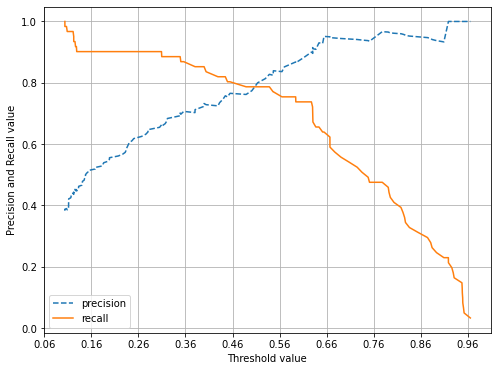

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [17]:
# F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [18]:
# 앞서 작성한 get_clf_eval() 함수에 F1스코어를 구하는 로직 추가
# get_eval_by_threshold() 함수를 이용해 임곗값 0.4 ~ 0.6별로 정확도, 정밀도, 재현율, F1스코어
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # F1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1:0.7786
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


In [19]:
# ROC 곡선과 AUC
# 민감도(TPR)은 실제값 positive가 정확히 예측돼야 하는 수준
# 특이도(TNR)은 실제값 negative가 정확히 예측돼야 하는 수준
# x축 FPR = FP / (FP + TN)
# y축 TPR = 1 - 특이성
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TRP 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값: [0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임곗값별 TPR: [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


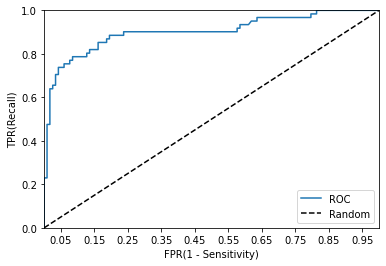

In [20]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X축, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

In [21]:
# get_clf_eval() 정확도, 정밀도, 재현율, F1 스코어, ROC AUC값 출력
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC_AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC_AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
    F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))